# Open Ocean
# Open Earth Fundation
---------------------------------------------------------------------------------------------------------------------
Authors: Margaux Filippi & Maureen Fonseca

---------------------------------------------------------------------------------------------------------------------

<h1> Step 2: calculate different metrics for each modulating factor </h1>
    
This notebook is the second part of the Step1_Curate_IUCN_RedList.ipynb

<h2> Modulating Factor 3.1: Endemic Species  </h2>

It is difficult to find endemic species in the ocean because they have more freedom of movement there than species on land. So, endemism is an important factor to consider in the importance of protecting a specific place in the ocean.

<h2> Data needed for this project </h2>

The data was output by `Step1_Curate_IUCN_RedList.ipynb` and can be found under [IUCN_RedList](https://drive.google.com/drive/folders/1waEAtfQwErhBKH3GkTHZXIlbadzH3HYu?usp=share_link) under a temporary folder that accompagnies the GitHub repository: 

`Ocean Program > data > data_processed > ACMC_IUCN_RedList`

### Importing libraries

In [1]:
import geopandas as gpd

In [2]:
import numpy as np
import pandas as pd

In [3]:
import os
import glob

In [4]:
from shapely.geometry import Polygon, Point

In [5]:
import fiona; #help(fiona.open)

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
import timeit

In [8]:
from netCDF4 import Dataset
import cmocean
import geopandas as gpd
from matplotlib.ticker import LinearLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable

OEF functions

In [9]:
from marinebiodiversity_utils import *

<h1> 2.1. Load data </h1>

<h2> 2.1.1 Get the conservation area</h2>

Mostly for plotting.

<h3> Coordinates for Cocos Island </h3>

Cocos Island is located at 05°31′41″N; 87°03′40″W

In [10]:
Cocos_lat = 5+31/60+41/3600
Cocos_lon = -(87+3/60+40/3600)
Cocos = Point(Cocos_lon, Cocos_lat)

<h3> Import entire ACMC </h3>

ACMC is the acronyms for the entire conservation area: Cocos Marine Conservation Area

In [11]:
ACMC = gpd.read_file('../Data/Geospatial_ACMC/ACMC.shp')

Inspect the Coordinate Reference Systems (CRS).

In [12]:
ACMC = ACMC.set_crs(epsg=4326, allow_override=True)

In [13]:
ACMC.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<h2> 2.1.2 Get the species data </h2>

This is the outcome from `Step1_Curate_IUCN_RedList.ipynb`.

In [18]:
df = gpd.read_file('../Data/ACMC_IUCN_data/gdf_ACMC_IUCN_range_status_filtered.shp') 

In [19]:
df.head()

,index,ASSESSMENT,ID_NO,BINOMIAL,PRESENCE,ORIGIN,SEASONAL,COMPILER,YEAR,CITATION,LEGEND,SUBSPECIES,SUBPOP,DIST_COMM,ISLAND,TAX_COMM,redlistCat,scientific,geometry
0,13,1504292,177964,Ctenochaetus marginatus,1,1,1,Jonnell Sanciangco,2010,International Union for Conservation of Nature...,Extant (resident),None,None,None,None,None,Least Concern,Ctenochaetus marginatus,"MULTIPOLYGON (((173.90343 3.44131, 173.90535 3..."
1,62,1604964,180245,Holothuria kefersteinii,1,1,1,IUCN,2012,International Union for Conservation of Nature,Extant (resident),None,None,None,None,None,Data Deficient,Holothuria kefersteinii,"MULTIPOLYGON (((-117.10683 32.44577, -117.1034..."
2,69,1614313,180318,Holothuria imitans,1,1,1,IUCN,2012,International Union for Conservation of Nature,Extant (resident),None,None,None,None,None,Least Concern,Holothuria imitans,"MULTIPOLYGON (((132.11722 -2.12133, 132.11264 ..."
3,76,1621878,180373,Isostichopus fuscus,1,1,1,IUCN,2012,International Union for Conservation of Nature,Extant (resident),None,None,None,None,None,Endangered,Isostichopus fuscus,"MULTIPOLYGON (((-114.81055 31.82298, -114.7885..."
4,95,1735660,183294,Strongylura exilis,1,1,1,IUCN,2018,IUCN (International Union for Conservation of ...,Extant (resident),None,None,None,None,None,Least Concern,Strongylura exilis,"MULTIPOLYGON (((-91.24865 -0.67985, -91.24889 ..."


<h1> 2.2 Preliminary calculations </h1> 

In [20]:
area_of_conservation = ACMC.geometry.item()

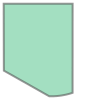

In [21]:
area_of_conservation

Note: Maybe this modulating factor can have another name, because we can obtain more information from it, as local species or migratory species.

## 2.2.1 Distribution Ratio #2

Let's to define a distribution ratio based on the distribution area within total conservation area and the total distribution area for each species:

DistRatio 2 = $\frac{\text{distribution area within total conservation area}}{\text{total distribution area}}$

**Analysis - Scenarios**

Here we can have 3 scenarios:

1. `Distribution Ratio 2 > 1`
- This makes no sense because its implies that the distribution area within total conservation area is biggest that its total distribution area
2. `Distribution Ratio 2 = 1` 
- This implies that these species are endemic and their distribution total area is the same of the ACMC area
3. `Distribution Ratio 2 < 1` 

    3.1 When Distribution `Ratio 2 is close to 1`: 
- This means that these species aren't endemic of ACMC but they could be local species (e.g East Central Pacific)

    3.2 When Distribution `Ratio 2 << 1`: 
- These species are migratory
- They might visit ACMC seasonally and they can travel long distances
- You can find them in other parts of the ocean around the world

Maps examples: https://towardsdatascience.com/plot-choropleth-maps-with-shapefiles-using-geopandas-a6bf6ade0a49
https://stackoverflow.com/questions/65507374/plotting-a-geopandas-dataframe-using-plotly

**Method 1:**

Using 'intersect'

In [25]:
# Make new columns
df["DistRatio2"] = 0
df["DistFactorPerc2"] = 0
DistRatio2 = []
DistFactorPerc2 = []

for iter, row in df.iterrows():
    
    df_intersect = df[df.BINOMIAL==row.BINOMIAL].intersection(area_of_conservation)
    ratio2 = (df_intersect.area/df[df.BINOMIAL==row.BINOMIAL].area).sum()

    DistRatio2.append(ratio2)
    DistFactorPerc2.append(100*ratio2)

In [29]:
df["DistRatio2"] = DistRatio2
df["DistFactorPerc2"] = DistFactorPerc2

**Method 2:**

Using 'clip'

In [30]:
# Now remove all geometries that are outside the ACMC -> clip does the job

df2 = gpd.clip(df.set_crs(epsg=4326, allow_override=True), ACMC)

In [31]:
df2["DistRatio2"] = df2.area/df.area
df2["DistFactorPerc2"] = 100 * df2.DistRatio2

/tmp/ipykernel_498/3251184085.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df2["DistRatio2"] = df2.area/df.area


Text(0.5, 1.0, 'Plot 1: Distribution Ratio 2 using two different filtered methods')

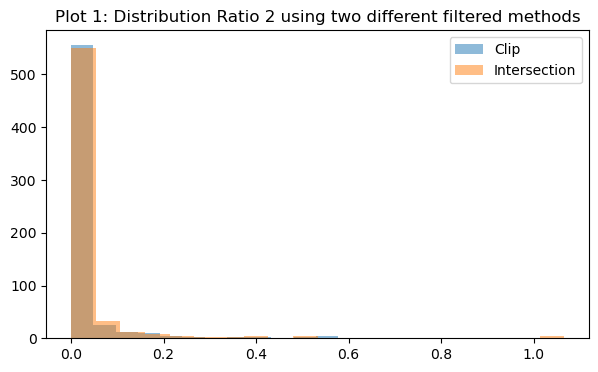

In [67]:
plt.figure(figsize=(7,4))
plt.hist(df2['DistRatio2'],bins=20, alpha=0.5, label = 'Clip')
plt.hist(df['DistRatio2'],bins=20, alpha=0.5, label = 'Intersection')
plt.legend()
plt.title('Plot 1: Distribution Ratio 2 using two different filtered methods')

With the method 1 (Intersection) are species that have: 

$\frac{\text{distribution area within total conservation area}}{\text{total distribution area}} > 1$

and that have not sense in the reality

But, with the method 2 (Clip) that doesn't happen, the maximum value is 1. 

It's more close to the reality.

Now, let's see how this data looks:

Text(0.5, 1.0, 'Plot 2: Distribution Ratio 2 using two different filtered methods')

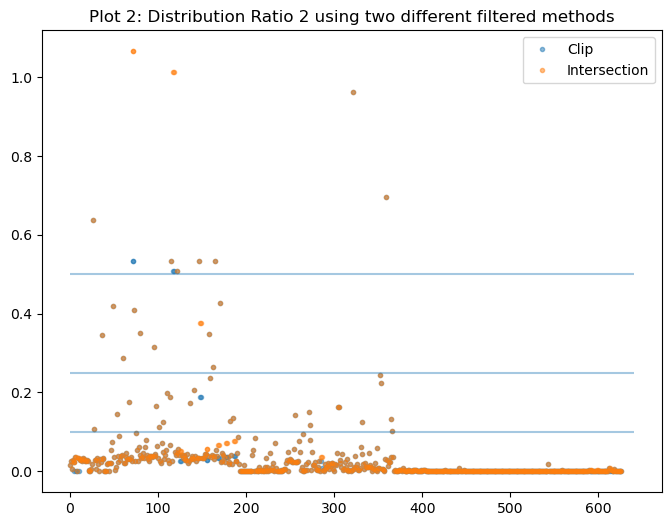

In [68]:
plt.figure(figsize=(8,6))
plt.plot(df2['DistRatio2'],'.', alpha=0.5, label = 'Clip')
plt.plot(df['DistRatio2'],'.', alpha=0.5, label = 'Intersection')
plt.legend()
plt.hlines(y=0.1,xmin=0, xmax=640,alpha=0.4)
plt.hlines(y=0.25,xmin=0, xmax=640,alpha=0.4)
plt.hlines(y=0.5,xmin=0, xmax=640,alpha=0.4)
plt.title('Plot 2: Distribution Ratio 2 using two different filtered methods')

In this plot we can see:
1. With method 1, the maximum value is greater than 1.
2. With method 2, the maximun value is 1.
3. For both methods, the most of the species has a small distribution ratio 2 [0 - 0.1], it means that the total distribution area is biggest than conservation area (ACMC), so these species could be migratory or global species.
4. Also, if the species have a distribution ratio 2 between [0.25-0.50], these species could only belong to the Pacific.
5. In addition, if distribution ratio 2 is > 0.50, these species could be considered local.

**Here we have the following issue:**

The result to get distribution area within total conservation area per species depends of the method that we use, in this case was 'intersection' and 'clip'.

The method 2 seems to be more appropriate.

**Verify:**

### 2.2.1.1 Maximum ratios

**Method 1**

In [43]:
print("The species with the highest ratio of conservation area with method 1:")
df[df.DistRatio2==np.max(df.DistRatio2)]

The species with the highest ratio of conservation area with method 1:


,index,ASSESSMENT,ID_NO,BINOMIAL,PRESENCE,ORIGIN,SEASONAL,COMPILER,YEAR,CITATION,...,SUBSPECIES,SUBPOP,DIST_COMM,ISLAND,TAX_COMM,redlistCat,scientific,geometry,DistRatio2,DistFactorPerc2
71,721,8090443,183305,Xyrichtys victori,1,1,1,IUCN,2009,International Union for Conservation of Nature...,...,None,None,None,None,None,Vulnerable,Xyrichtys victori,"MULTIPOLYGON (((-86.13105 5.59887, -86.12913 5...",1.066127,106.612717
72,722,8090443,183305,Xyrichtys victori,1,1,1,IUCN,2010,International Union for Conservation of Nature...,...,None,None,None,None,None,Vulnerable,Xyrichtys victori,"MULTIPOLYGON (((-86.13105 5.59887, -86.12913 5...",1.066127,106.612717


Let's see what species have `DistRatio2 >= 1` in df

In [44]:
for x in range(len(df)):
    if df.DistRatio2[x] >= 1:
        print('The species is: '+str(df.BINOMIAL[x]))
        print('with DistRatio2: '+str(df.DistRatio2[x]))

The species is: Xyrichtys victori
with DistRatio2: 1.0661271749386128
The species is: Xyrichtys victori
with DistRatio2: 1.0661271749386128
The species is: Halichoeres discolor
with DistRatio2: 1.0143868688681699
The species is: Halichoeres discolor
with DistRatio2: 1.0143868688681699


**Method 2**

In [90]:
print("The species with the highest ratio of conservation area with method 2:")
print(df2[df2.DistRatio2==np.max(df2.DistRatio2)].BINOMIAL)
print(df2[df2.DistRatio2==np.max(df2.DistRatio2)].DistRatio2)

The species with the highest ratio of conservation area with method 2:
321    Dicrolene gregoryi
Name: BINOMIAL, dtype: object
321    0.962473
Name: DistRatio2, dtype: float64


In this case, we have different species with the maximun DistRatio 2

### 2.2.1.2 Minimun ratios

**Method 1**

In [53]:
print("The species with the lowest ratio of conservation area:")
print(df[df.DistRatio2==np.min(df.DistRatio2)].BINOMIAL)
print(df[df.DistRatio2==np.min(df.DistRatio2)].DistRatio2)

The species with the lowest ratio of conservation area:
264    Lophodolos indicus
Name: BINOMIAL, dtype: object
264    0.000008
Name: DistRatio2, dtype: float64


**Method 2**

In [56]:
print("The species with the lowest ratio of conservation area:")
print(df2[df2.DistRatio2==np.min(df2.DistRatio2)].BINOMIAL)
print(df2[df2.DistRatio2==np.min(df2.DistRatio2)].DistRatio2)

The species with the lowest ratio of conservation area:
264    Lophodolos indicus
Name: BINOMIAL, dtype: object
264    0.000008
Name: DistRatio2, dtype: float64


In this case, it has the same species with the smallest ratio of conservation area

## 2.2.2 Plots

**Method 1**

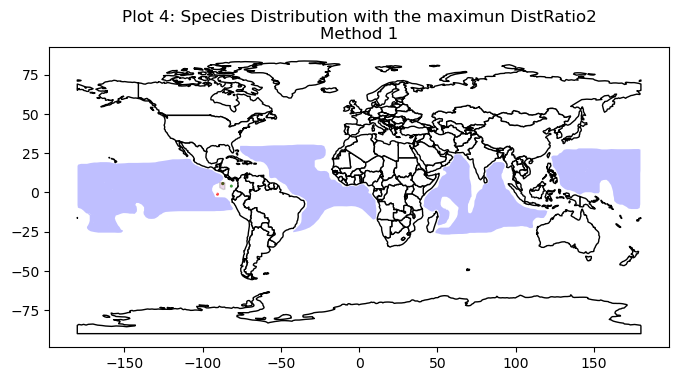

In [106]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
fig, ax = plt.subplots(figsize=(8,8))

ax.set_aspect('equal')

world.plot(ax=ax, color='white', edgecolor='black')

df[df.BINOMIAL == 'Xyrichtys victori' ].plot(ax = ax, color = 'r', alpha = 0.5)
df[df.BINOMIAL == 'Halichoeres discolor' ].plot(ax = ax, color = 'g', alpha = 0.5)
df[df.DistRatio2==np.min(df.DistRatio2)].plot(ax = ax, color = 'b', alpha = 0.25)

ACMC.plot(ax=ax, alpha = 0.15, color = 'purple', edgecolor='black')

#ax.set_xlim((-110, -60))
#ax.set_ylim((-50, 60))
plt.title('Plot 4: Species Distribution with the maximun DistRatio2\nMethod 1')
plt.show();

Let's see more close to ACMC:

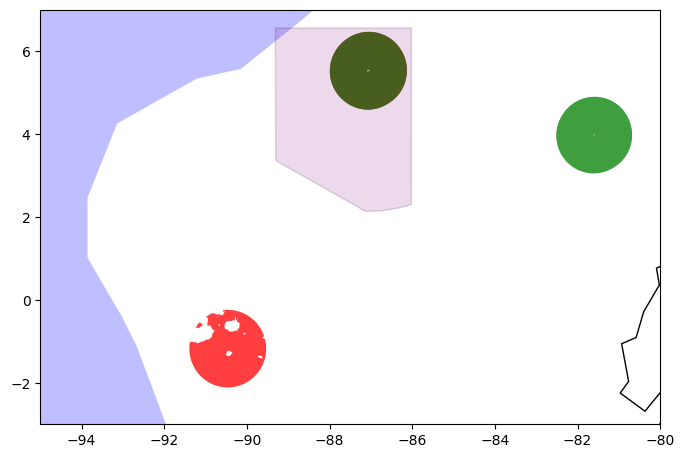

In [117]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
fig, ax = plt.subplots(figsize=(8,8))

ax.set_aspect('equal')

world.plot(ax=ax, color='white', edgecolor='black')

df[df.BINOMIAL == 'Xyrichtys victori' ].plot(ax = ax, color = 'r', alpha = 0.5)
df[df.BINOMIAL == 'Halichoeres discolor' ].plot(ax = ax, color = 'g', alpha = 0.5)
df[df.DistRatio2==np.min(df.DistRatio2)].plot(ax = ax, color = 'b', alpha = 0.25)

ACMC.plot(ax=ax, alpha = 0.15, color = 'purple', edgecolor='black')

ax.set_xlim((-95, -80))
ax.set_ylim((-3, 7))
plt.show();

**Method 2**

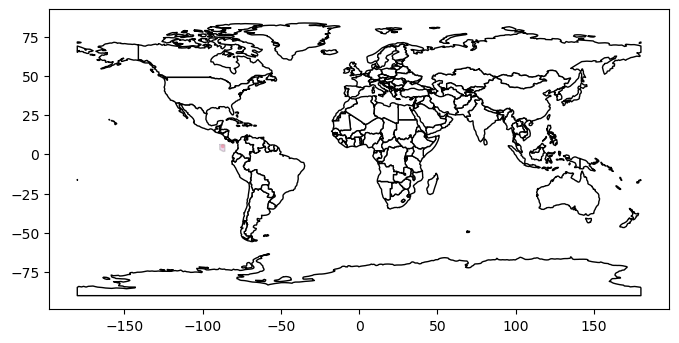

In [134]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
fig, ax = plt.subplots(figsize=(8,8))

ax.set_aspect('equal')

world.plot(ax=ax, color='white', edgecolor='black')

df2[df2.DistRatio2==np.max(df2.DistRatio2)].plot(ax = ax, color = 'r', alpha = 0.25)
df2[df2.DistRatio2==np.min(df2.DistRatio2)].plot(ax = ax, color = 'b', alpha = 0.5)

ACMC.plot(ax=ax, alpha = 0.15, color = 'purple', edgecolor='black')

#ax.set_xlim((-89.5, -86))
#ax.set_ylim((2, 7))
plt.show();

Let's see more close to ACMC:

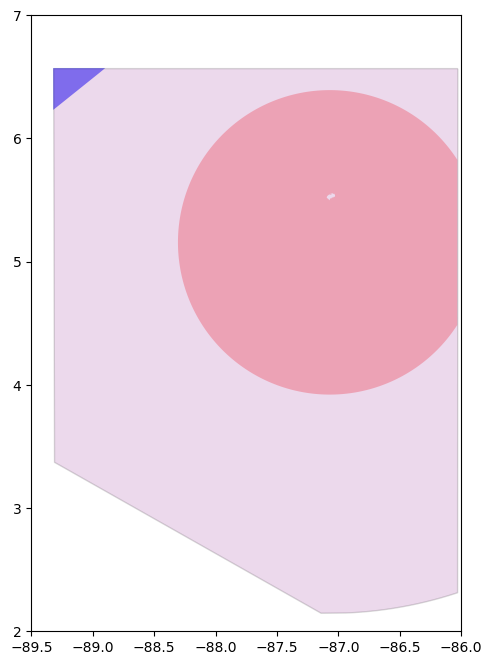

In [132]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
fig, ax = plt.subplots(figsize=(8,8))

ax.set_aspect('equal')

world.plot(ax=ax, color='white', edgecolor='black')

df2[df2.DistRatio2==np.max(df2.DistRatio2)].plot(ax = ax, color = 'r', alpha = 0.25)
df2[df2.DistRatio2==np.min(df2.DistRatio2)].plot(ax = ax, color = 'b', alpha = 0.5)

ACMC.plot(ax=ax, alpha = 0.15, color = 'purple', edgecolor='black')

ax.set_xlim((-89.5, -86))
ax.set_ylim((2, 7))
plt.show();

<AxesSubplot:>

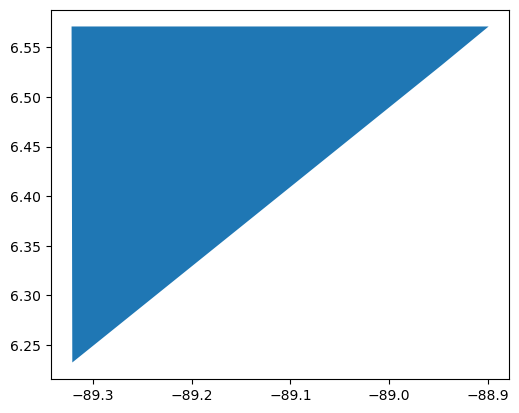

In [136]:
df2[df2.BINOMIAL=='Lophodolos indicus'].plot()

Mmm!

Interesting.. in this case this species have the lowest DistRatio2 because its polygon of distribution is small, but it isn't in other part of the ocean

**Next Steps**
1) Choose what method it's the most appropriate for this kind of analysis 
2) Figure out how we can convert this information in a base unit
- Per species?
- Per DistRatio 2 range?
- Combination of them?

... to be continued.